In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from numba import jit
import warnings

@jit(nopython=True, fastmath=True)
def compute_errors_numba(neighbor_clouds, max_iter=50, eps=1e-5):
    n_samples, k, dim = neighbor_clouds.shape
    errors = np.empty(n_samples, dtype=np.float64)
    
    for i in range(n_samples):
        cloud = neighbor_clouds[i]
        
        y = np.zeros(dim)
        for d in range(dim):
            sum_val = 0.0
            for j in range(k):
                sum_val += cloud[j, d]
            y[d] = sum_val / k
            
        for _ in range(max_iter):
            sum_weights = 0.0
            y_next = np.zeros(dim)
            distances = np.empty(k)
            all_non_zero = True
            
            for j in range(k):
                dist_sq = 0.0
                for d in range(dim):
                    diff = cloud[j, d] - y[d]
                    dist_sq += diff * diff
                dist = np.sqrt(dist_sq)
                distances[j] = dist
                
                if dist < 1e-10: 
                    all_non_zero = False
                    for d in range(dim): y[d] = cloud[j, d]
                    break
                
                w = 1.0 / dist
                sum_weights += w
                for d in range(dim):
                    y_next[d] += cloud[j, d] * w
            
            if not all_non_zero: break 
            
            diff_norm_sq = 0.0
            for d in range(dim):
                y_next[d] /= sum_weights
                diff = y[d] - y_next[d]
                diff_norm_sq += diff * diff
                y[d] = y_next[d]
                
            if np.sqrt(diff_norm_sq) < eps:
                break
        
        total_dist = 0.0
        for j in range(k):
            dist_sq = 0.0
            for d in range(dim):
                diff = cloud[j, d] - y[d]
                dist_sq += diff * diff
            total_dist += np.sqrt(dist_sq)
            
        errors[i] = total_dist / k
        
    return errors

def check_embedding_condition(data, threshold=1e10):
    data_centered = data - np.mean(data, axis=0)
    s = np.linalg.svdvals(data_centered)
    if s[-1] < 1e-12:
        return np.inf
    return s[0] / s[-1]

def power_law_model(k, intercept, coef, gamma):
    return intercept + coef * (k ** gamma)

# Estimate intrinsic stochasticity at fixed k
import numpy as np
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors

def estimate_intrinsic_stochasticity(
    embedding_data,
    pushforward,
    k=50,
    n_samples=5000,
    cond_threshold=1000,
    random_state=0,
    return_pointwise=False,
    theiler_w=0,          
    buffer_mult=6,        
    pre_scaled=False,     
    strict_theiler=True,  
):
    if k <= 1:
        raise ValueError("k must be >= 2.")
    if pushforward <= 0:
        raise ValueError("pushforward must be >= 1.")
    if theiler_w < 0:
        raise ValueError("theiler_w must be >= 0.")
    if buffer_mult < 1:
        raise ValueError("buffer_mult must be >= 1.")

    if pre_scaled:
        data_norm = np.asarray(embedding_data)
    else:
        scaler = RobustScaler()
        data_norm = scaler.fit_transform(np.asarray(embedding_data))

    cond_num = check_embedding_condition(data_norm)
    if (cond_num > cond_threshold) or np.isinf(cond_num):
        warnings.warn(
            f"CRITICAL WARNING: Rank Deficient! Condition Number = {cond_num:.2e}. Skipping."
        )
        return None

    T = data_norm.shape[0]
    max_start = T - pushforward
    if max_start <= 0:
        raise ValueError("Pushforward too large for the given data length.")

    X_curr = data_norm[:max_start]
    Y_fut  = data_norm[pushforward:]

    rng = np.random.default_rng(random_state)
    n_q = int(min(n_samples, max_start))
    query_idx = rng.choice(max_start, size=n_q, replace=False)

    k_query = int(min(max_start, max(k * buffer_mult, k + 2 * theiler_w + 5)))
    nbrs = NearestNeighbors(n_neighbors=k_query, algorithm="auto", n_jobs=-1).fit(X_curr)

    dist_raw, idx_raw = nbrs.kneighbors(X_curr[query_idx]) 

    nn_idx = np.empty((n_q, k), dtype=np.int64)
    rk = np.empty(n_q, dtype=np.float64)  

    not_enough = 0

    for r in range(n_q):
        q = int(query_idx[r])
        cand = idx_raw[r]
        cand_d = dist_raw[r]

        picked = 0
        last_d = 0.0

        for j in range(k_query):
            t = int(cand[j])
            if t == q:
                continue
            if theiler_w > 0 and (abs(t - q) <= theiler_w):
                continue
            nn_idx[r, picked] = t
            last_d = float(cand_d[j])  
            picked += 1
            if picked == k:
                break

        if picked < k:
            not_enough += 1
            if strict_theiler:
                raise RuntimeError(
                    f"[Theiler window] Not enough valid neighbors after exclusion: "
                    f"query_index={q}, picked={picked} < k={k}. "
                    f"Try increasing buffer_mult (current={buffer_mult}) or decreasing theiler_w (current={theiler_w}), "
                    f"or reducing k / n_samples."
                )
            else:
                picked2 = 0
                last_d = 0.0
                for j in range(k_query):
                    t = int(cand[j])
                    if t == q:
                        continue
                    nn_idx[r, picked2] = t
                    last_d = float(cand_d[j])
                    picked2 += 1
                    if picked2 == k:
                        break

        rk[r] = last_d

    neighbor_clouds = Y_fut[nn_idx]  # (n_q, k, d)

    local_errors = compute_errors_numba(neighbor_clouds)
    E_star_k = float(np.mean(local_errors))

    out = {
        "E_star_k": E_star_k,
        "k": int(k),
        "pushforward": int(pushforward),
        "theiler_w": int(theiler_w),
        "n_queries": int(n_q),
        "condition_number": float(cond_num),
        "not_enough_queries": int(not_enough),
        "strict_theiler": bool(strict_theiler),
        "median_rk": float(np.median(rk)),
        "q90_rk": float(np.quantile(rk, 0.90)),
        "mean_rk": float(np.mean(rk)),
    }
    if return_pointwise:
        out["pointwise_errors"] = local_errors
        out["query_idx"] = query_idx
        out["nn_idx"] = nn_idx
        out["rk"] = rk
    return out

In [4]:
from scipy.integrate import solve_ivp

In [5]:
def cord_rhs(t, state, a=0.25, b=4.0, F=8.0, G=1.0):
    x, y, z = state

    dx = -y - z - a * x + a * F
    dy = x * y - b * x * z - y + G
    dz = b * x * y + x * z - z

    return [dx, dy, dz]

def cord_x_x_x(x,y,z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
    x_dot = x
    y_dot = -y - z - a*x + a*F 
    z_dot = a*a*(x - F) - G + (1+a)*(y+z) - (1+b)*x*y + (b-1)*x*z
    return np.array([x_dot, y_dot, z_dot])
def cord_y_y_y(x,y,z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
    x_dot = y
    y_dot = x*y - b*x*z - y + G
    z_dot = -b*x*(b*x*y + x*z - z) + (x-1)*(G-b*x*z + x*y - y) + (b*z - y)*(-a*F + a*x + y + z)
    return np.array([x_dot, y_dot, z_dot])
def cord_z_z_z(x,y,z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
    x_dot = z
    y_dot = b*x*y + x*z - z
    z_dot = b*x*(G - b*x*z + x*y - y) + (x-1)*(b*x*y + x*z - z) - (b*y + z)*(y + z + a*x - a*F)
    return np.array([x_dot, y_dot, z_dot])

a, b, F, G = 0.25, 4.0, 8.0, 1.0

t_span = (0.0, 200.0)
t_eval = np.linspace(*t_span, 20001)   
x0 = [1.0, 1.0, 1.0]                  

sol = solve_ivp(
    cord_rhs,
    t_span,
    x0,
    t_eval=t_eval,
    args=(a, b, F, G),
    rtol=1e-8,
    atol=1e-10,
)

x, y, z = sol.y
x_x_x = cord_x_x_x(x,y,z).T
y_y_y = cord_y_y_y(x,y,z).T 
z_z_z = cord_z_z_z(x,y,z).T

PUSHFORWARD = 20
K = 50
N_SAMPLES = 5000
COND_THRESHOLD = 1000
THEILER_W = 30
BUFFER_MULT = 6

embeddings = {
    "x_x_x": x_x_x,
    "y_y_y": y_y_y,
    "z_z_z": z_z_z,
}

n_repeats = 10
base_seed = 10  # 起始随机种子

summary = {}
all_runs = {}

for name, embedding in embeddings.items():
    vals = []
    runs = []
    for r in range(n_repeats):
        out = estimate_intrinsic_stochasticity(
            embedding_data=embedding,
            pushforward=PUSHFORWARD,
            k=K,
            n_samples=N_SAMPLES,
            cond_threshold=COND_THRESHOLD,
            random_state=base_seed + r,
            return_pointwise=False,
            theiler_w=THEILER_W,
            buffer_mult=BUFFER_MULT,
            pre_scaled=False,
            strict_theiler=True,
        )
        v = np.nan if (out is None) else float(out["E_star_k"])
        vals.append(v)
        runs.append(out)
    arr = np.asarray(vals, dtype=float)

    summary[name] = {
        "mean": float(np.nanmean(arr)),
        "std": float(np.nanstd(arr, ddof=0)),
        "n_ok": int(np.isfinite(arr).sum()),
    }
    all_runs[name] = runs

print("=== Cord System ===")
for name, s in summary.items():
    print(f"{name:6s}: {s['mean']:.6f} ± {s['std']:.6f}   (n_ok={s['n_ok']}/{n_repeats})")

=== Cord System ===
x_x_x : 0.979241 ± 0.017570   (n_ok=10/10)
y_y_y : 2.011495 ± 0.024735   (n_ok=10/10)
z_z_z : 1.490004 ± 0.031781   (n_ok=10/10)


In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import jit, vmap

jax.config.update("jax_enable_x64", True)

def simulate_solve_ivp(f_np, y0, t0, t1, dt, rtol=1e-9, atol=1e-12, burn_in_frac=0.2):
    t_eval = np.arange(t0, t1 + 1e-12, dt)
    sol = solve_ivp(lambda t, y: f_np(t, y), (t0, t1), y0, t_eval=t_eval, rtol=rtol, atol=atol)
    Y = sol.y.T  # (T, d)
    burn = int(len(Y) * burn_in_frac)
    return t_eval[burn:], Y[burn:]

def make_lie_derivative_funcs(F_jax, max_order):
    """
    Return list of vmap+jit funcs:
    deriv_funcs[k](X) -> (T, d) equals L_f^k id evaluated at each state in X.
    """
    def make_single(order):
        if order == 0:
            return lambda x: x
        prev = make_single(order - 1)
        def curr(x):
            _, out_tan = jax.jvp(prev, (x,), (F_jax(x),))
            return out_tan
        return curr

    funcs = []
    for k in range(max_order + 1):
        fk = jit(vmap(make_single(k)))
        funcs.append(fk)
    return funcs

def eval_all_derivatives(trajectory_np, deriv_funcs):
    X = jnp.array(trajectory_np)
    out = []
    for k, fk in enumerate(deriv_funcs):
        out.append(np.array(fk(X)))  # (T, d)
    return out

def build_embeddings_from_derivs(all_derivs, specs):
    """
    all_derivs[k]: (T, d) for k-th Lie derivative of identity map.
    specs: dict name -> list of (order, component_index).
           returns embedding_data (T, m) with m=len(list).
    """
    T = all_derivs[0].shape[0]
    emb_dict = {}
    for name, coords in specs.items():
        M = len(coords)
        E = np.empty((T, M), dtype=np.float64)
        for j, (order, idx) in enumerate(coords):
            E[:, j] = all_derivs[order][:, idx]
        emb_dict[name] = E
    return emb_dict

In [8]:
# ---------------- Lorenz-63 ----------------
def lorenz63_np(t, s, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = s
    return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z], dtype=np.float64)

@jit
def lorenz63_jax(x, sigma=10.0, rho=28.0, beta=8/3):
    X, Y, Z = x
    return jnp.array([sigma*(Y-X), X*(rho-Z)-Y, X*Y-beta*Z])

# simulate
dt = 0.01
t_eval, traj = simulate_solve_ivp(lambda t,y: lorenz63_np(t,y), y0=[1,1,1], t0=0, t1=80, dt=dt)

# Lie derivatives up to 2 (enough for 3D differential embeddings like (x, xdot, xddot))
MAX_ORDER = 2
Fjax = lambda x: lorenz63_jax(x)
deriv_funcs = make_lie_derivative_funcs(Fjax, MAX_ORDER)
all_derivs = eval_all_derivatives(traj, deriv_funcs)  # list of (T,3)

# embedding candidates (3D)
# (x, xdot, xddot) = (order0 x0, order1 x0, order2 x0)
# (y, ydot, yddot), (z, zdot, zddot)
# multivariate: (x, y, xdot) etc
specs = {
    "x_x_x": [(0,0),(1,0),(2,0)],
    "y_y_y": [(0,1),(1,1),(2,1)],
    "z_z_z": [(0,2),(1,2),(2,2)]
}
embeddings = build_embeddings_from_derivs(all_derivs, specs)

# run E*
PUSHFORWARD = 20  # 20 steps -> 0.2 time for dt=0.01
K = 50
N_SAMPLES = 5000
THEILER_W = 30
BUFFER_MULT = 6
COND_THRESHOLD = 1000

print("\n=== Lorenz-63 E* ranking ===")
rows = []
for name, E in embeddings.items():
    out = estimate_intrinsic_stochasticity(
        embedding_data=E,
        pushforward=PUSHFORWARD,
        k=K,
        n_samples=N_SAMPLES,
        cond_threshold=COND_THRESHOLD,
        random_state=0,
        theiler_w=THEILER_W,
        buffer_mult=BUFFER_MULT,
        pre_scaled=False,
        strict_theiler=True,
    )
    rows.append((name, np.nan if out is None else out["E_star_k"]))
rows = sorted(rows, key=lambda x: (np.inf if np.isnan(x[1]) else x[1]))
for name, v in rows:
    print(f"{name:8s}  E*={v}")



=== Lorenz-63 E* ranking ===
x_x_x     E*=0.21395056361270873
y_y_y     E*=0.3418074450664868
z_z_z     E*=0.384500792170981


In [7]:
# ---------------- Duffing (forced) ----------------
# x'' + delta x' + alpha x + beta x^3 = gamma cos(omega t)
def duffing_np(t, s, delta=0.2, alpha=-1.0, beta=1.0, gamma=0.3, omega=1.2):
    x, v = s
    dx = v
    dv = -delta*v - alpha*x - beta*(x**3) + gamma*np.cos(omega*t)
    return np.array([dx, dv], dtype=np.float64)

@jit
def duffing_jax(x, delta=0.2, alpha=-1.0, beta=1.0, gamma=0.3, omega=1.2):
    # NOTE: autonomous trick not used; Lie-derivatives for non-autonomous require augmenting phase.
    # For simplicity: augment phase theta as state (see below).
    return x  # placeholder

# --- Augment with phase theta to make autonomous 3D system: (x, v, theta), theta' = omega ---
def duffing_aut_np(t, s, delta=0.2, alpha=-1.0, beta=1.0, gamma=0.3, omega=1.2):
    x, v, th = s
    dx = v
    dv = -delta*v - alpha*x - beta*(x**3) + gamma*np.cos(th)
    dth = omega
    return np.array([dx, dv, dth], dtype=np.float64)

@jit
def duffing_aut_jax(s, delta=0.2, alpha=-1.0, beta=1.0, gamma=0.3, omega=1.2):
    x, v, th = s
    dx = v
    dv = -delta*v - alpha*x - beta*(x**3) + gamma*jnp.cos(th)
    dth = omega
    return jnp.array([dx, dv, dth])

def run_duffing_case(tag, gamma):
    dt = 0.01
    t_eval, traj = simulate_solve_ivp(
        lambda t,y: duffing_aut_np(t,y, gamma=gamma),
        y0=[0.1, 0.0, 0.0],
        t0=0, t1=400, dt=dt, burn_in_frac=0.3
    )
    Fjax = lambda x: duffing_aut_jax(x, gamma=gamma)
    MAX_ORDER = 2
    all_derivs = eval_all_derivatives(traj, make_lie_derivative_funcs(Fjax, MAX_ORDER))  # (T,3)

    # build embeddings for observing x only (x, xdot, xddot) from the augmented system
    specs = {
        "x_x_x": [(0,0),(1,0),(2,0)],
        "v_v_v": [(0,1),(1,1),(2,1)],
    }
    emb = build_embeddings_from_derivs(all_derivs, specs)

    PUSHFORWARD = 50  # 0.5 time (dt=0.01) -- adjust as you like
    out_rows = []
    for name, E in emb.items():
        out = estimate_intrinsic_stochasticity(
            embedding_data=E, pushforward=PUSHFORWARD,
            k=50, n_samples=5000, cond_threshold=1000,
            random_state=0, theiler_w=30, buffer_mult=6,
            pre_scaled=False, strict_theiler=True
        )
        out_rows.append((name, np.nan if out is None else out["E_star_k"]))
    out_rows = sorted(out_rows, key=lambda x: (np.inf if np.isnan(x[1]) else x[1]))
    print(f"\n=== Duffing ({tag}) gamma={gamma} ===")
    for n,v in out_rows:
        print(f"{n:6s}  E*={v}")

# Typical: smaller gamma -> more regular; larger gamma -> chaotic (depends on parameters)
run_duffing_case("more-regular", gamma=0.20)
run_duffing_case("more-chaotic",  gamma=0.30)


=== Duffing (more-regular) gamma=0.2 ===
x_x_x   E*=0.0031338092348345697
v_v_v   E*=0.005756274097613783

=== Duffing (more-chaotic) gamma=0.3 ===
x_x_x   E*=0.09833956721244286
v_v_v   E*=0.16986333760129785


In [9]:
# ---------------- Henon map (discrete) ----------------
def henon_map(a=1.4, b=0.3, x0=0.1, y0=0.1, N=50000, burn=5000):
    x = np.empty(N+1); y = np.empty(N+1)
    x[0]=x0; y[0]=y0
    for n in range(N):
        x[n+1] = 1 - a*(x[n]**2) + y[n]
        y[n+1] = b*x[n]
    return np.column_stack([x[burn:], y[burn:]])

def delay_embed(series, m=3, tau=1):
    # series: (T,) -> (T-(m-1)tau, m)
    T = len(series)
    L = T - (m-1)*tau
    return np.stack([series[i:i+L] for i in range(0, m*tau, tau)], axis=1)

traj = henon_map()
x = traj[:,0]
E = delay_embed(x, m=3, tau=1)  # (x_t, x_{t-2}, x_{t-4})

out = estimate_intrinsic_stochasticity(
    embedding_data=E,
    pushforward=5,   # 5 map-steps
    k=50,
    n_samples=5000,
    cond_threshold=1000,
    random_state=0,
    theiler_w=10,
    buffer_mult=6,
    pre_scaled=False,
    strict_theiler=True,
)
print("\nHenon delay embedding E* =", out["E_star_k"] if out else None)


Henon delay embedding E* = 0.058078991618656095


In [ ]:
from scipy.integrate import odeint
def rayleigh_benard_9d(x, t, sigma, b1, b2, b3, b4, b5, b6, R):
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = x
    
    dx1 = -sigma * b1 * x1 - x2 * x4 + b4 * x4**2 + b3 * x3 * x5 - sigma * b2 * x7
    dx2 = -sigma * x2 + x1 * x4 - x2 * x5 + x4 * x5 - (sigma * x9) / 2
    dx3 = -sigma * b1 * x3 + x2 * x4 - b4 * x2**2 - b3 * x1 * x5 + sigma * b2 * x8
    dx4 = -sigma * x4 - x2 * x3 - x2 * x5 + x4 * x5 + (sigma * x9) / 2
    dx5 = -sigma * b5 * x5 + (x2**2 / 2) - (x4**2 / 2)
    dx6 = -b6 * x6 + x2 * x9 - x4 * x9
    dx7 = -b1 * x7 - R * x1 + 2 * x5 * x8 - x4 * x9
    dx8 = -b1 * x8 + R * x3 - 2 * x5 * x7 + x2 * x9
    dx9 = -x9 - R * x2 + R * x4 - 2 * x2 * x6 + 2 * x4 * x6 + x4 * x7 - x2 * x8
    
    return np.array([dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8, dx9])

sigma = 0.5
b1 = 5/1.5
b2 = 0.6
b3 = 1.2
b4 = 0.2
b5 = 2/1.5
b6 = 4/1.5
R = 15.1

x0 = [0.01, 0, 0.01, 0, 0, 0, 0, 0, 0.01]

t = np.linspace(0, 200, 200000)  

sol = odeint(rayleigh_benard_9d, x0, t, args=(sigma, b1, b2, b3, b4, b5, b6, R))

In [15]:
import time
import jax
import jax.numpy as jnp
from jax import jit, vmap

sigma = 0.5
b1 = 5/1.5
b2 = 0.6
b3 = 1.2
b4 = 0.2
b5 = 2/1.5
b6 = 4/1.5
R = 15.1

@jit
def F_jax(x):
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = x
    
    dx1 = -sigma * b1 * x1 - x2 * x4 + b4 * x4**2 + b3 * x3 * x5 - sigma * b2 * x7
    dx2 = -sigma * x2 + x1 * x4 - x2 * x5 + x4 * x5 - (sigma * x9) / 2
    dx3 = -sigma * b1 * x3 + x2 * x4 - b4 * x2**2 - b3 * x1 * x5 + sigma * b2 * x8
    dx4 = -sigma * x4 - x2 * x3 - x2 * x5 + x4 * x5 + (sigma * x9) / 2
    dx5 = -sigma * b5 * x5 + (x2**2 / 2) - (x4**2 / 2)
    dx6 = -b6 * x6 + x2 * x9 - x4 * x9
    dx7 = -b1 * x7 - R * x1 + 2 * x5 * x8 - x4 * x9
    dx8 = -b1 * x8 + R * x3 - 2 * x5 * x7 + x2 * x9
    dx9 = -x9 - R * x2 + R * x4 - 2 * x2 * x6 + 2 * x4 * x6 + x4 * x7 - x2 * x8
    
    return jnp.array([dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8, dx9])

def rayleigh_benard_scipy(x_val, t):
    x = x_val
    dx = np.zeros(9)
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = x
    dx[0] = -sigma * b1 * x1 - x2 * x4 + b4 * x4**2 + b3 * x3 * x5 - sigma * b2 * x7
    dx[1] = -sigma * x2 + x1 * x4 - x2 * x5 + x4 * x5 - (sigma * x9) / 2
    dx[2] = -sigma * b1 * x3 + x2 * x4 - b4 * x2**2 - b3 * x1 * x5 + sigma * b2 * x8
    dx[3] = -sigma * x4 - x2 * x3 - x2 * x5 + x4 * x5 + (sigma * x9) / 2
    dx[4] = -sigma * b5 * x5 + (x2**2 / 2) - (x4**2 / 2)
    dx[5] = -b6 * x6 + x2 * x9 - x4 * x9
    dx[6] = -b1 * x7 - R * x1 + 2 * x5 * x8 - x4 * x9
    dx[7] = -b1 * x8 + R * x3 - 2 * x5 * x7 + x2 * x9
    dx[8] = -x9 - R * x2 + R * x4 - 2 * x2 * x6 + 2 * x4 * x6 + x4 * x7 - x2 * x8
    return dx

print("Starting Numerical Simulation...")
x0 = [0.01, 0, 0.01, 0, 0, 0, 0, 0, 0.01]
t = np.linspace(0, 200, 200000)
sol = odeint(rayleigh_benard_scipy, x0, t)

transient_steps = int(len(t) * 0.3)
trajectory = sol[transient_steps:] # Shape (T, 9)
trajectory_jax = jnp.array(trajectory)
print(f"Simulation complete. Trajectory shape: {trajectory.shape}")

print("Computing Lie Derivatives using JAX (Automatic Differentiation)...")
start_time = time.time()

def make_derivative_func(order):
    if order == 0:
        return lambda x: x
    
    prev_func = make_derivative_func(order - 1)
    
    def curr_func(x):
        _, out_tangent = jax.jvp(prev_func, (x,), (F_jax(x),))
        return out_tangent
    
    return curr_func

MAX_ORDER = 8
derivative_funcs = [jit(vmap(make_derivative_func(i))) for i in range(MAX_ORDER + 1)]

All_Derivatives_Data = []
for order in range(MAX_ORDER + 1):
    print(f"Evaluating Order {order} on GPU/CPU...")
    d_vals = derivative_funcs[order](trajectory_jax)
    All_Derivatives_Data.append(np.array(d_vals))

print(f"Derivatives calculated in {(time.time() - start_time):.2f}s")

Starting Numerical Simulation...
Simulation complete. Trajectory shape: (140000, 9)
Computing Lie Derivatives using JAX (Automatic Differentiation)...
Evaluating Order 0 on GPU/CPU...
Evaluating Order 1 on GPU/CPU...
Evaluating Order 2 on GPU/CPU...
Evaluating Order 3 on GPU/CPU...
Evaluating Order 4 on GPU/CPU...
Evaluating Order 5 on GPU/CPU...
Evaluating Order 6 on GPU/CPU...
Evaluating Order 7 on GPU/CPU...
Evaluating Order 8 on GPU/CPU...
Derivatives calculated in 33.55s



Starting Observability Analysis (E* Estimation via estimate_intrinsic_stochasticity)...
Analyzing Differential Embedding for X1...
-> E*(X1): 7.602523 ± 0.000000   (n_ok=1/1)
Analyzing Differential Embedding for X2...
-> E*(X2): 9.527160 ± 0.000000   (n_ok=1/1)
Analyzing Differential Embedding for X3...
-> E*(X3): 6.560856 ± 0.000000   (n_ok=1/1)
Analyzing Differential Embedding for X4...
-> E*(X4): 8.939888 ± 0.000000   (n_ok=1/1)
Analyzing Differential Embedding for X5...
-> E*(X5): 5.856668 ± 0.000000   (n_ok=1/1)
Analyzing Differential Embedding for X6...
-> E*(X6): 31.207790 ± 0.000000   (n_ok=1/1)
Analyzing Differential Embedding for X7...
-> E*(X7): 22.403463 ± 0.000000   (n_ok=1/1)
Analyzing Differential Embedding for X8...
-> E*(X8): 21.525391 ± 0.000000   (n_ok=1/1)
Analyzing Differential Embedding for X9...
-> E*(X9): 28.341212 ± 0.000000   (n_ok=1/1)

--- Summary of Results (sorted by mean E*) ---
X5: 5.856668 ± 0.000000   (n_ok=1/1)
X3: 6.560856 ± 0.000000   (n_ok=1/1)
X1

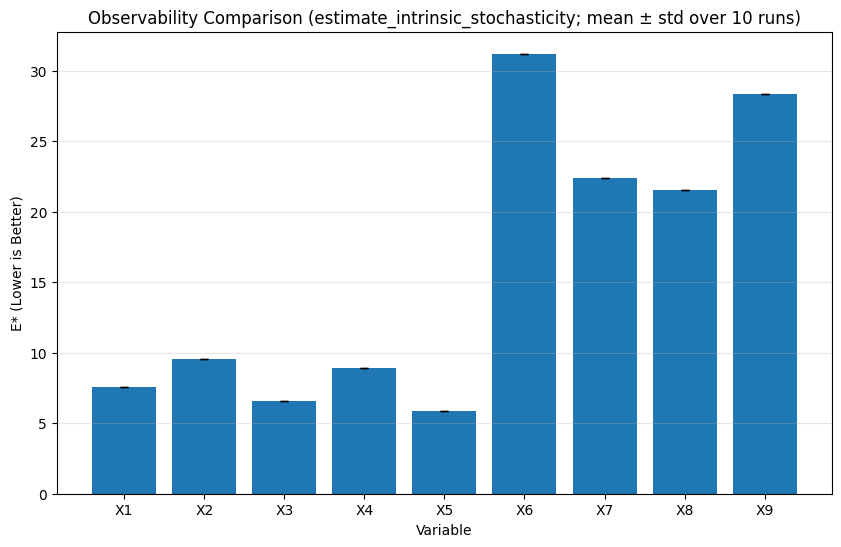

In [22]:
print("\nStarting Observability Analysis (E* Estimation via estimate_intrinsic_stochasticity)...")

P = 20      
K_KNN = 50  
N_SAMPLES = 5000

COND_THRESHOLD = 2000
THEILER_W = 300      
BUFFER_MULT = 6
N_REPEATS = 1
BASE_SEED = 42

results = {}    
results_std = {} 
results_nok = {} 

for i in range(9):
    var_name = f"X{i+1}"
    print(f"Analyzing Differential Embedding for {var_name}...")

    embedding_data = np.zeros((trajectory.shape[0], 9))
    for order in range(9):
        embedding_data[:, order] = All_Derivatives_Data[order][:, i]

    vals = []
    for r in range(N_REPEATS):
        out = estimate_intrinsic_stochasticity(
            embedding_data=embedding_data,
            pushforward=P,
            k=K_KNN,
            n_samples=N_SAMPLES,
            cond_threshold=COND_THRESHOLD,
            random_state=BASE_SEED + r,
            return_pointwise=False,
            theiler_w=THEILER_W,
            buffer_mult=BUFFER_MULT,
            pre_scaled=False,
            strict_theiler=True,
        )
        v = np.nan if (out is None) else float(out["E_star_k"])
        vals.append(v)

    arr = np.asarray(vals, dtype=float)
    mean_val = float(np.nanmean(arr)) if np.isfinite(arr).any() else np.nan
    std_val  = float(np.nanstd(arr, ddof=0)) if np.isfinite(arr).any() else np.nan
    n_ok = int(np.isfinite(arr).sum())

    results[var_name] = mean_val
    results_std[var_name] = std_val
    results_nok[var_name] = n_ok

    print(f"-> E*({var_name}): {mean_val:.6f} ± {std_val:.6f}   (n_ok={n_ok}/{N_REPEATS})")


print("\n--- Summary of Results (sorted by mean E*) ---")
sorted_items = sorted(results.items(), key=lambda kv: kv[1] if np.isfinite(kv[1]) else np.inf)

for name, mean_val in sorted_items:
    std_val = results_std[name]
    n_ok = results_nok[name]
    print(f"{name}: {mean_val:.6f} ± {std_val:.6f}   (n_ok={n_ok}/{N_REPEATS})")

import matplotlib.pyplot as plt

valid_names = [k for k in results.keys() if np.isfinite(results[k])]
valid_means = [results[k] for k in valid_names]
valid_stds  = [results_std[k] for k in valid_names]

plt.figure(figsize=(10, 6))
plt.bar(valid_names, valid_means, yerr=valid_stds, capsize=3)
plt.xlabel("Variable")
plt.ylabel("E* (Lower is Better)")
plt.title("Observability Comparison (estimate_intrinsic_stochasticity; mean ± std over 10 runs)")
plt.grid(axis='y', alpha=0.3)
plt.show()